In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

# def check_convergence(L, tolerance=0.001):
#     N = len(L)
#     if N < 3:
#         return False

#     # Calculate the mean and standard deviation
#     sample_mean = np.mean(L)
#     sample_std = np.std(L, ddof=1)

#     # Calculate the confidence interval width
#     z = 1.96  # For approximately 95% confidence
#     ci_half_width = z * (sample_std / np.sqrt(N))

#     # Check if the mean is stable
#     if N > 2:
#         prev_mean = np.mean(L[:-1])
#         mean_change = abs((sample_mean - prev_mean) / prev_mean)
#         if mean_change > tolerance:
#             return False

#     # Check if confidence interval is narrow enough
#     relative_ci_width = 2 * ci_half_width / sample_mean
#     if relative_ci_width > tolerance:
#         return False

#     return True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [412]:
def check_convergence(L, base_tolerance=0.01, min_tolerance=1e-8, mean_previous_graph_size=None):

    if len(L) < 3:
        return False

    if mean_previous_graph_size == None:
        return False

    current_mean = np.mean(L)

    dif_mean_previous_graph_size = np.abs((current_mean - mean_previous_graph_size) / mean_previous_graph_size)

    adaptive_tolerance = np.max((dif_mean_previous_graph_size * base_tolerance, min_tolerance))

    dif_mean_previous_sampling = np.abs((np.mean(L) - np.mean(L[:-1])) / np.mean(L[:-1]))

    print(f"\nCurrent dif = {dif_mean_previous_sampling} vs. adaptive tol = {adaptive_tolerance}\n")

    if dif_mean_previous_sampling > adaptive_tolerance:
        return False
    else:
        return True

In [413]:
def sequential_Newton(guesses, eigs):
    """Search for closeish convergence. Then search for full convergence. 
    Then clean solutions (get rid of neg, too large, nans)"""
    solutions = []
    for guess in guesses:
        solution = eigs(guess, solve_type="SVD iterate", printerval=np.inf, tol=1e-4, max_steps=20)
        solutions.append(solution)
        _, index = np.unique(np.round(solutions, 3), return_index=True)
        solutions = list(np.array(solutions)[index])
    full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=10, tol=1e-13, max_steps=20)
    _, inds = np.unique(np.round(full_solutions, 8), return_index=True)

    full_solutions = full_solutions[inds]
    mask_too_small = full_solutions < 2
    mask_too_big = full_solutions > 5
    mask_isnan = np.isnan(full_solutions)
    mask_good = ~ (mask_too_small | mask_too_big | mask_isnan)
    full_solutions = full_solutions[mask_good]

    return full_solutions

In [414]:
nums_Vs = (10**np.linspace(3, 5, 11)).astype(int)[:8]
print(nums_Vs)

[ 1000  1584  2511  3981  6309 10000 15848 25118]


In [ ]:
for en, num_Vs in enumerate(nums_Vs):
    print(f"\n\ngraph size = {en + 1} / {len(nums_Vs)}\n\n\n")

    if num_Vs < 900:
        guesses = np.linspace(3.5, 4.5, 40)
    elif num_Vs < 2000:
        guesses = np.linspace(3.9, 4.45, 30)
    elif num_Vs < 4000:
        guesses = np.linspace(4.1, 4.4, 20)
    else:
        guesses = np.linspace(4.18, 4.32, 16)

    if en == 0:
        check = True
    else:
        means = list(np.mean(eigenvalues[num_Vs], axis=1))
        seed = len(eigenvalues[num_Vs]) - 1
        previous_mean = np.mean(eigenvalues[nums_Vs[en - 1]])
        check = check_convergence(means, mean_previous_graph_size=previous_mean)

    while not check:
        seed += 1
        np.random.seed(seed)
        rd = construct_graph.patch_graph.Random_Delaunay(num_Vs)
        g = construct_graph.patch_graph.Patch(rd)
        print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        full_solutions = sequential_Newton(guesses, eigs)
        if len(full_solutions) != 4:
            eigenvalues[num_Vs].append(["bad", full_solutions])
        else:
            eigenvalues[num_Vs].append(full_solutions)
            means.append(np.mean(full_solutions))
            print(full_solutions)
            print(means)

        check = check_convergence(means, mean_previous_graph_size=previous_mean)



graph size = 1 / 8





graph size = 2 / 8




Current dif = 3.998600529448446e-06 vs. adaptive tol = 2.138108580875828e-05



graph size = 3 / 8




Current dif = 1.9755143869720177e-05 vs. adaptive tol = 1.7541744404665632e-05


SEED = 13, num_Vs = 2511


Calculating eig number 0

----------------------
Converged at step 2:

k = 4.121008605108884
----------------------

Calculating eig number 1

----------------------
Converged at step 1:

k = 4.235303171261653
----------------------

Calculating eig number 2

----------------------
Converged at step 2:

k = 4.247004866467121
----------------------

Calculating eig number 3

----------------------
Converged at step 2:

k = 4.309040646201698
----------------------
[4.12100861 4.23530317 4.24700487 4.30904065]
[4.241778123930125, 4.237047963793329, 4.246783885739128, 4.240127521486459, 4.240009605590725, 4.234003997388853, 4.238584825692646, 4.244111357972305, 4.23982360602163, 4.23985337885423, 4.237164237036612, 4.244563029523521, 

In [404]:
check_convergence(means, mean_previous_graph_size=previous_mean)

False

In [339]:
temp_eigs = []
for seed in [5]:
    np.random.seed(seed)
    rd = construct_graph.patch_graph.Random_Delaunay(25118)
    g = construct_graph.patch_graph.Patch(rd)
    print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    full_solutions = sequential_Newton(np.linspace(4, 4.54, 300), eigs)
    temp_eigs.append(full_solutions)


SEED = 5, num_Vs = 25118


Calculating eig number 0

----------------------
Converged at step 2:

k = 4.240827932498065
----------------------

Calculating eig number 1

----------------------
Converged at step 2:

k = 4.260169257641228
----------------------

Calculating eig number 2

----------------------
Converged at step 1:

k = 4.2705817391219085
----------------------


In [273]:
continuum_eigenvalue = 0.918**0.5 * 2 * np.pi / np.sqrt(2)
print(continuum_eigenvalue)

4.256829064033469


In [340]:
temp_eigs

[array([4.24082793, 4.26016926, 4.27058174])]

In [323]:
print(temp_eigs[0][0])
print(temp_eigs[0][1])
print(temp_eigs[0][2])

4.240827932498091
4.260169257641215
4.270581739121882


In [365]:
total_means = []
for num_Vs in eigenvalues:
    total_means.append(np.mean(eigenvalues[num_Vs]))

total_means = np.array(total_means)

In [366]:
total_means

array([4.2241758 , 4.23304811, 4.23993532, 4.24541153, 4.24957001,
       4.25367537, 4.25592786, 4.25645869])

In [371]:
np.abs((total_means[-1] - total_means[-2]) / total_means[-2]) * 0.01

1.2472751554425627e-06

In [336]:
difs_total_means = np.array([np.abs(total_means[i] - total_means[i+1]) for i in range(len(total_means) - 1)])
difs_nums_Vs = np.array([np.abs(nums_Vs[i] - nums_Vs[i+1]) for i in range(len(nums_Vs) - 1)])

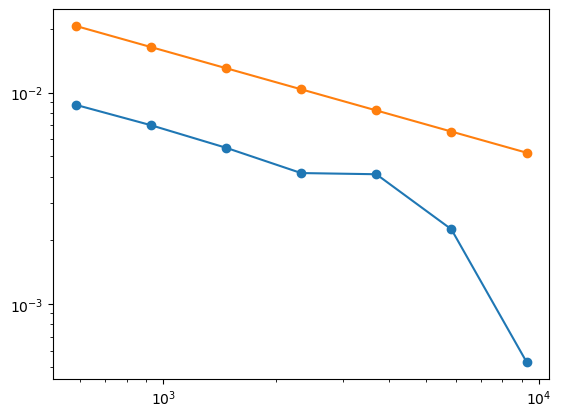

In [337]:
plt.loglog(difs_nums_Vs, difs_total_means, "o-")
plt.loglog(difs_nums_Vs, difs_nums_Vs**(-0.5) / 2, "o-")

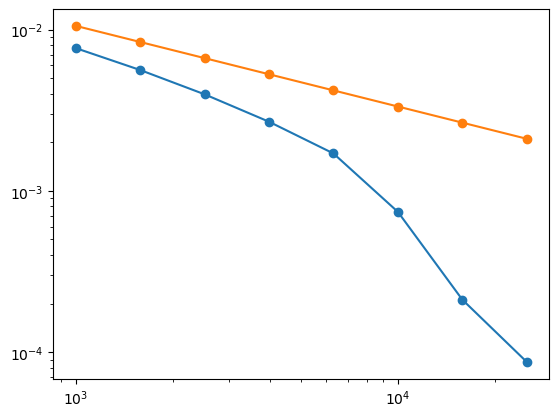

In [338]:
plt.loglog(list(eigenvalues.keys()), np.abs(total_means - continuum_eigenvalue) / continuum_eigenvalue, "o-")
plt.loglog(list(eigenvalues.keys()), np.array(list(eigenvalues.keys()))**(-0.5) / 3, "o-")

# Calculations for coefficients

In [258]:
sphere_coefficient = 0.9202712102263128

0.9202712102263128

In [267]:
nums_Vs = (10**np.linspace(2, 5, 16)).astype(int)[:13]
nums_seeds = 5 * [128] + 3 * [64] + 3 * [32]

In [268]:
print(nums_Vs)
print(nums_seeds)

[  100   158   251   398   630  1000  1584  2511  3981  6309 10000 15848
 25118]
[128, 128, 128, 128, 128, 64, 64, 64, 32, 32, 32]


## Get coefficients by calculation or import

### Calculate coefficients

In [36]:
coefficients = {}
for num_Vs, num_seeds in zip(nums_Vs, nums_seeds):
    print(f"NUM VERTICES = {num_Vs}\n")
    coefficients[num_Vs] = []
    for num_seed in range(num_seeds):
        print(f"{num_seed + 1} / {num_seeds}")
        np.random.seed(num_seed)
        rd = construct_graph.patch_graph.Random_Delaunay(num_Vs)
        g = construct_graph.patch_graph.Patch(rd)
        eq = construct_graph.patch_graph.Cell_Problem(g)
        xi = eq.solve_corrector_equation()
        coefficients[num_Vs].append(eq.construct_homogenized_tensor(xi))

NUM VERTICES = {num_Vs}


1 / 128
2 / 128
3 / 128
4 / 128
5 / 128
6 / 128
7 / 128
8 / 128
9 / 128
10 / 128
11 / 128
12 / 128
13 / 128
14 / 128
15 / 128
16 / 128
17 / 128
18 / 128
19 / 128
20 / 128
21 / 128
22 / 128
23 / 128
24 / 128
25 / 128
26 / 128
27 / 128
28 / 128
29 / 128
30 / 128
31 / 128
32 / 128
33 / 128
34 / 128
35 / 128
36 / 128
37 / 128
38 / 128
39 / 128
40 / 128
41 / 128
42 / 128
43 / 128
44 / 128
45 / 128
46 / 128
47 / 128
48 / 128
49 / 128
50 / 128
51 / 128
52 / 128
53 / 128
54 / 128
55 / 128
56 / 128
57 / 128
58 / 128
59 / 128
60 / 128
61 / 128
62 / 128
63 / 128
64 / 128
65 / 128
66 / 128
67 / 128
68 / 128
69 / 128
70 / 128
71 / 128
72 / 128
73 / 128
74 / 128
75 / 128
76 / 128
77 / 128
78 / 128
79 / 128
80 / 128
81 / 128
82 / 128
83 / 128
84 / 128
85 / 128
86 / 128
87 / 128
88 / 128
89 / 128
90 / 128
91 / 128
92 / 128
93 / 128
94 / 128
95 / 128
96 / 128
97 / 128
98 / 128
99 / 128
100 / 128
101 / 128
102 / 128
103 / 128
104 / 128
105 / 128
106 / 128
107 / 128
108 / 128
10

#### Add new eigenvalues

In [ ]:
for num_Vs in nums_Vs[-1:]:
    print(f"NUM VERTICES = {num_Vs}\n")
    if not (num_Vs in coefficients):
        coefficients[num_Vs] = []
    seed_num = -1
    while not check_convergence(coefficients[num_Vs]):
        seed_num += 1
        np.random.seed(seed_num)
        print(seed_num)
        rd = Random_Delaunay(num_Vs)
        g = Patch(rd)
        eq = Cell_Problem(g)
        xi = eq.solve_corrector_equation()
        c = eq.construct_homogenized_tensor(xi)
        print(c)
        print()
        coefficients[num_Vs].append(c)
    print()

### Import coefficients

In [159]:
# file = open("data/delaunay_coefficients.pkl", "wb")
# pickle.dump(coefficients, file)
# file.close()

file = open("data/delaunay_coefficients.pkl", "rb")
coefficients = pickle.load(file)
file.close()

## Plot results

In [271]:
coefficients_means

array([0.89089586, 0.89584424, 0.90011407, 0.9035575 , 0.90734588,
       0.91027064, 0.91225905, 0.91326778, 0.91501134, 0.91602426,
       0.91727986, 0.91826039, 0.91846883])

In [262]:
coefficients_means = []
for num_Vs in coefficients:
    coefficients_means.append(np.mean(coefficients[num_Vs]))
coefficients_means = np.array(coefficients_means)

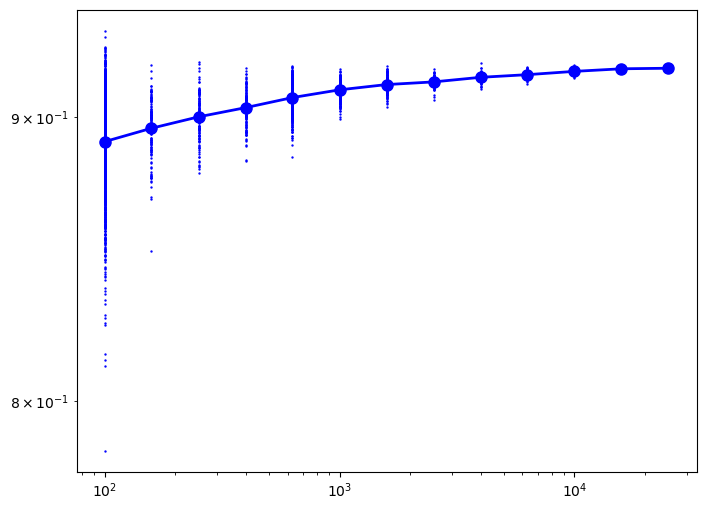

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(nums_Vs[:-1], coefficients_means, 'o-', markersize=8, c='b', linewidth=2)
for num_Vs in nums_Vs[:-1]:
    x = num_Vs * np.ones(len(coefficients[num_Vs]))
    y = coefficients[num_Vs]
    ax.scatter(x, y, s=0.5, c='b')

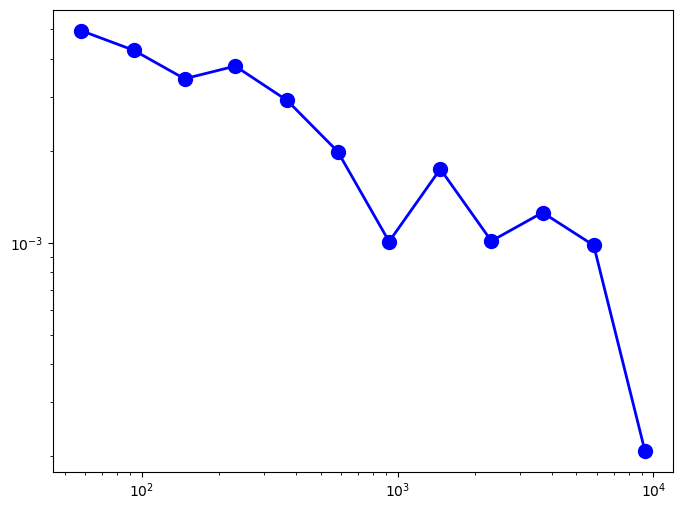

In [270]:
difs = [np.abs(coefficients_means[i] - coefficients_means[i + 1]) for i in range(len(coefficients_means) - 1)]
num_Vs_difs = [np.abs(nums_Vs[i] - nums_Vs[i + 1]) for i in range(len(coefficients_means) - 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(num_Vs_difs, difs, 'o-', markersize=10, c='b', linewidth=2)